In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

import Rakuten_preprocessing as rkt
from importlib import reload 
reload(rkt)

from Rakuten_preprocessing import Rakuten_img_path

c:\ProgramData\anaconda3\envs\Rakuten\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the data

In [2]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
target = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
target = prdtype.loc[target['prdtypecode'], 'prdtypedesignation'].reset_index()

## Function to plot results

In [3]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,2), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Dataframe for Image Generator

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Encoding classes as integers
encoder = LabelEncoder()
labels = encoder.fit_transform(target['prdtypedesignation'])

img_paths = Rakuten_img_path(img_folder=r"C:\Users\Julien Fournier\Documents\DST\RakutenProject\Data\images\image_train_resized",
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')

data_img = pd.DataFrame({'labels': labels, 'img_path': img_paths})

df_train, df_test = train_test_split(data_img, test_size=0.2, random_state=123, stratify=labels)

## Image generator

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

img_size = (224, 224, 3)

def ViT_preprocess_input(x):
    x = preprocess_input(x)
    x = x / 255.0  # Scale pixel values to 0-1
    x = x * 2 - 1  # Scale pixel values to -1 to 1
    return x

#Data generator for the train and test sets
train_data_generator = ImageDataGenerator(preprocessing_function=ViT_preprocess_input,
                                          rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                          horizontal_flip=True, fill_mode='constant', cval=0)

test_data_generator = ImageDataGenerator(preprocessing_function=ViT_preprocess_input, fill_mode='constant', cval=0)

train_generator = train_data_generator.flow_from_dataframe(dataframe=df_train, x_col='img_path', y_col='labels',
                                                           class_mode='raw', target_size=img_size[:2],
                                                           batch_size=64)

test_generator = test_data_generator.flow_from_dataframe(dataframe=df_test, x_col='img_path', y_col='labels',
                                                           class_mode='raw', shuffle=False, target_size=img_size[:2],
                                                           batch_size=64)

Found 67932 validated image filenames.
Found 16984 validated image filenames.


## Vision Transformer (ViT)

In [18]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input

num_class = len(np.unique(labels))

model_url = "https://www.kaggle.com/models/spsayakpaul/vision-transformer/frameworks/TensorFlow2/variations/vit-s16-fe/versions/1"
vit_model = hub.KerasLayer(model_url, trainable=False)

model = Sequential()
model.add(Input(shape=img_size))
model.add(vit_model)
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=num_class, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 384)               21665664  
                                                                 
 dense_10 (Dense)            (None, 128)               49280     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 27)                3483      
                                                                 
Total params: 21718427 (82.85 MB)
Trainable params: 52763 (206.11 KB)
Non-trainable params: 21665664 (82.65 MB)
_________________________________________________________________


In [21]:
history = model.fit(x=train_generator, validation_data=test_generator, epochs=2, verbose=True)

Epoch 1/2
 843/1062 [======================>.......] - ETA: 11:07 - loss: 1.4117 - accuracy: 0.5737

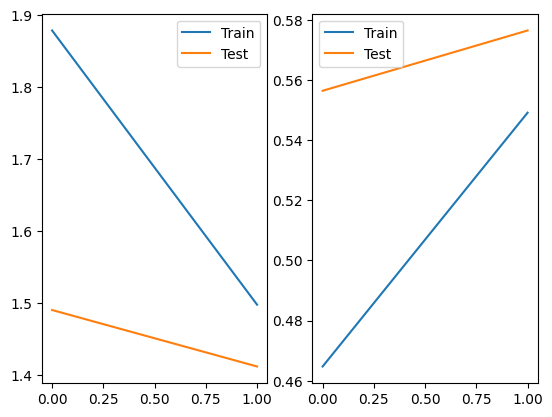

In [20]:
f, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Test')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Test')
axs[1].legend()

plt.show()

In [77]:
test_pred = model_vgg.predict(x=test_generator)

266/266 [==============================] - 222s 834ms/step


              precision    recall  f1-score   support

           0       0.27      0.20      0.23       341
           1       0.62      0.14      0.23       151
           2       0.73      0.90      0.80       791
           3       0.54      0.39      0.46       175
           4       0.56      0.53      0.55       176
           5       0.18      0.01      0.03       139
           6       0.48      0.55      0.51       552
           7       0.57      0.58      0.57       993
           8       0.30      0.07      0.11       415
           9       0.50      0.58      0.54      1006
          10       0.38      0.43      0.40       475
          11       0.54      0.28      0.37       298
          12       0.52      0.10      0.17       165
          13       0.37      0.37      0.37       944
          14       0.69      0.75      0.72       866
          15       0.52      0.60      0.56       979
          16       0.44      0.53      0.48       536
          17       0.36    

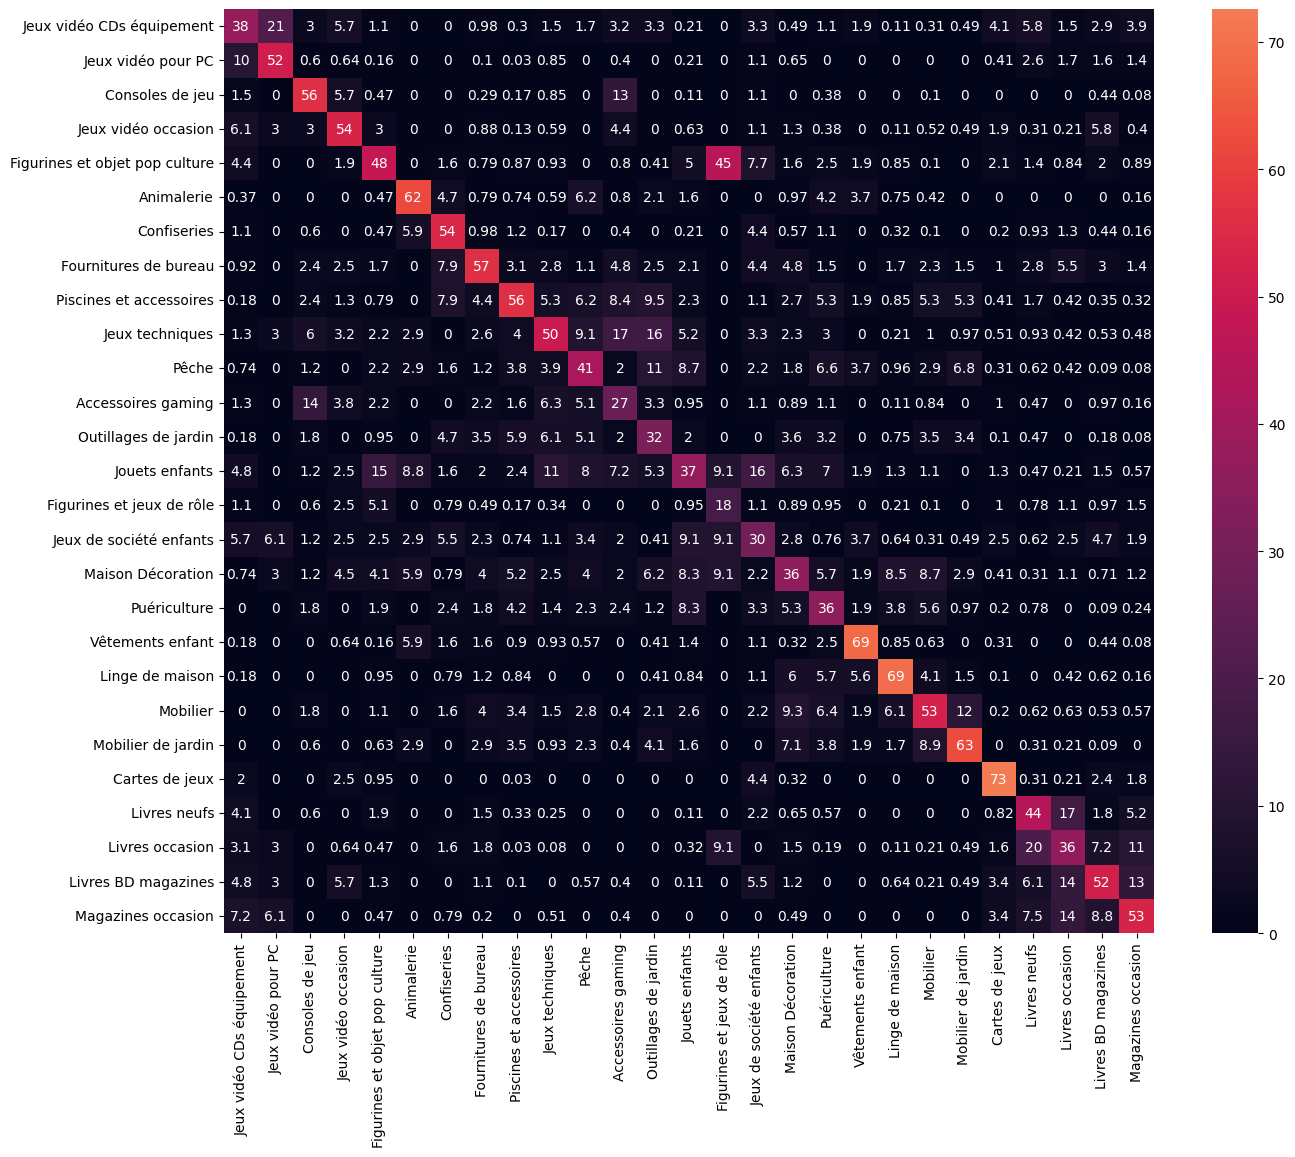

<module 'matplotlib.pyplot' from 'c:\\ProgramData\\anaconda3\\envs\\Rakuten\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [78]:
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(df_test['labels'], test_pred_class, index=encoder.classes_)

## ResNet50

In [62]:
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential, Model
from keras import regularizers
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D

num_class = len(np.unique(labels))

#imagenet with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size)
#freezing ResNet50 weights
for layer in base_model.layers:
    layer.trainable = False

model_resnet = Sequential()
model_resnet.add(base_model)

#adding layers for classification
# model_resnet.add(Dropout(rate=0.5))
model_resnet.add(GlobalAveragePooling2D()) #average over width and height, (although GlobalAveragePooling2D is already in resnet50 ...?)
model_resnet.add(Dense(units=128, activation='relu'))
model_resnet.add(Dropout(rate=0.5))
# # model_resnet.add(Dense(units=64, activation='relu'))
# # model_resnet.add(Dropout(rate=0.2))
model_resnet.add(Dense(units=num_class, activation='softmax'))

model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 128)               262272    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 27)                3483      
                                                                 
Total params: 23853467 (90.99 MB)
Trainable params: 265755 (1.01 MB)
Non-trainable params: 23587712 (89.98 MB)
________

In [47]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [63]:
history = model_resnet.fit(x=train_generator, validation_data=test_generator, epochs=10)

Epoch 1/10
1062/1062 [==============================] - 1213s 1s/step - loss: 2.0539 - accuracy: 0.4113 - val_loss: 1.6029 - val_accuracy: 0.5228
Epoch 2/10
1062/1062 [==============================] - 1214s 1s/step - loss: 1.7761 - accuracy: 0.4731 - val_loss: 1.5412 - val_accuracy: 0.5420
Epoch 3/10
1062/1062 [==============================] - 1219s 1s/step - loss: 1.7051 - accuracy: 0.4915 - val_loss: 1.4945 - val_accuracy: 0.5517
Epoch 4/10
1062/1062 [==============================] - 1170s 1s/step - loss: 1.6523 - accuracy: 0.5054 - val_loss: 1.4739 - val_accuracy: 0.5589
Epoch 5/10
1062/1062 [==============================] - 1151s 1s/step - loss: 1.6101 - accuracy: 0.5179 - val_loss: 1.4518 - val_accuracy: 0.5638
Epoch 6/10
1062/1062 [==============================] - 1150s 1s/step - loss: 1.5866 - accuracy: 0.5214 - val_loss: 1.4414 - val_accuracy: 0.5694
Epoch 7/10
1062/1062 [==============================] - 1149s 1s/step - loss: 1.5660 - accuracy: 0.5270 - val_loss: 1.4357 -

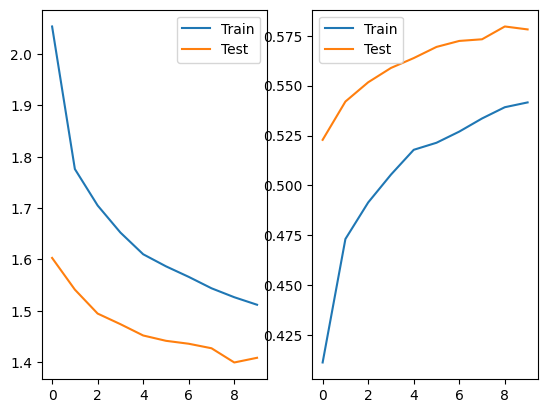

In [64]:
f, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Test')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Test')
axs[1].legend()

plt.show()

266/266 [==============================] - 155s 576ms/step
              precision    recall  f1-score   support

           0       0.40      0.43      0.41       336
           1       0.77      0.24      0.37       165
           2       0.84      0.93      0.88       791
           3       0.73      0.60      0.66       161
           4       0.66      0.66      0.66       166
           5       0.59      0.29      0.39       153
           6       0.68      0.60      0.64       534
           7       0.70      0.66      0.68       998
           8       0.27      0.25      0.26       414
           9       0.61      0.68      0.65      1009
          10       0.49      0.57      0.52       502
          11       0.59      0.50      0.54       284
          12       0.62      0.26      0.37       174
          13       0.46      0.33      0.38       974
          14       0.86      0.70      0.77       861
          15       0.57      0.69      0.62       955
          16       0.6

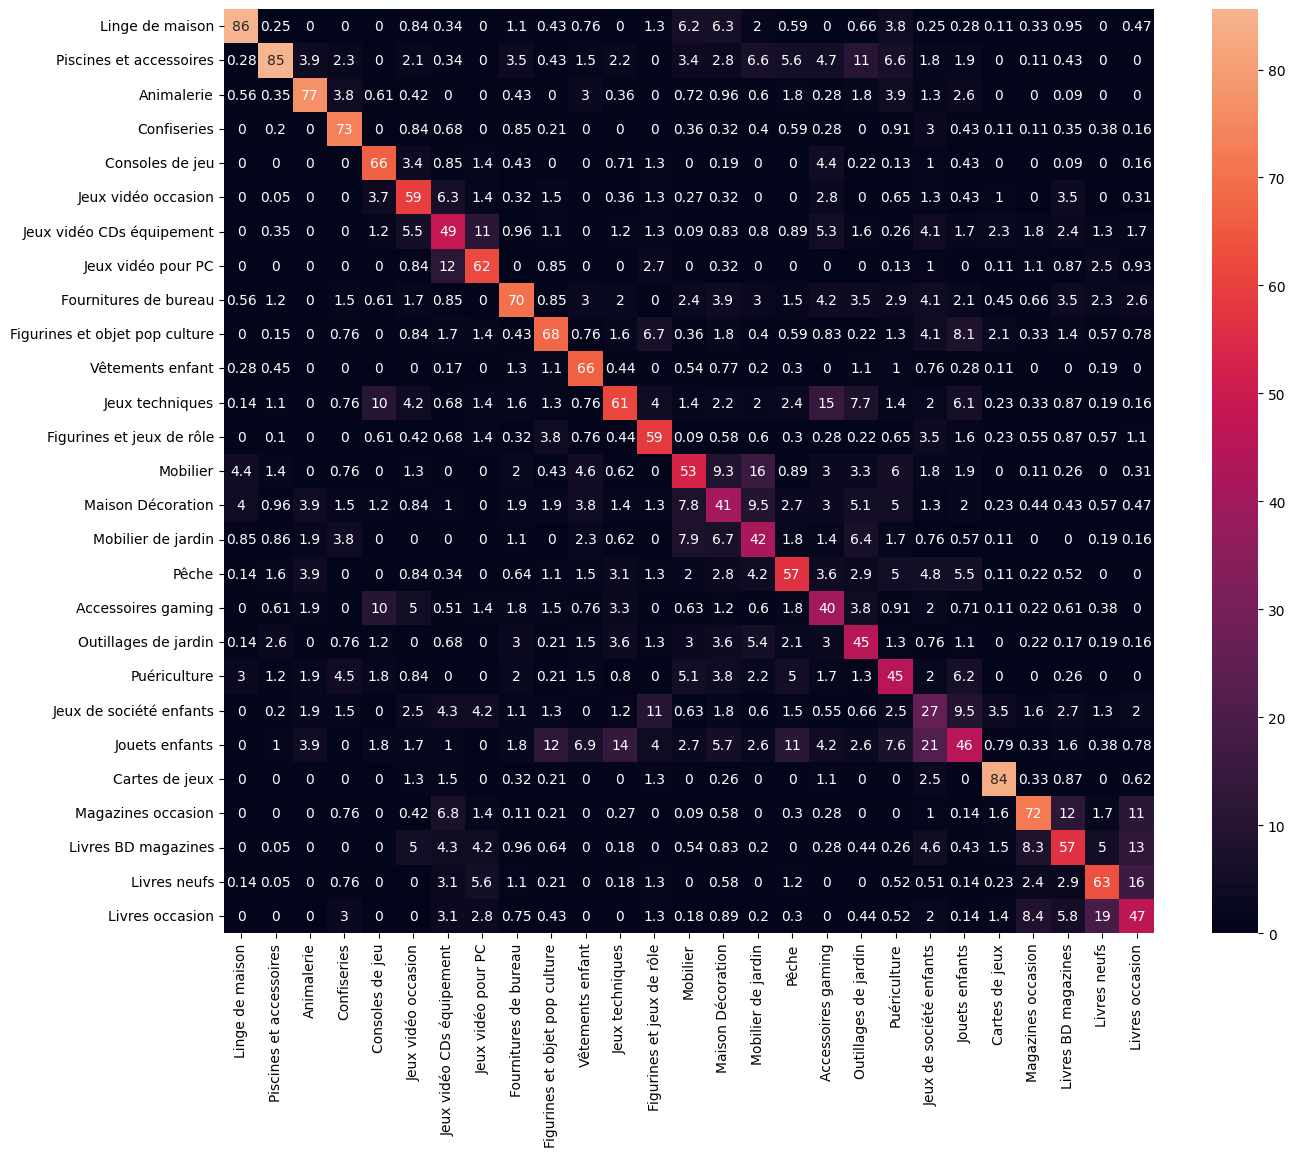

<module 'matplotlib.pyplot' from 'c:\\ProgramData\\anaconda3\\envs\\Rakuten\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [24]:
test_pred = model_resnet.predict(x=test_generator)
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(df_test['labels'], test_pred_class, index=encoder.classes_)

In [25]:
from sklearn.metrics import f1_score

f1_score(df_test['labels'], test_pred_class, average='weighted')

0.6019637168193839